In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pytz

# 1. Working with solar data

In [530]:
df_solar = pd.read_csv('../datasets/solar_p_data/data_solar.csv', delimiter=';')

In [531]:
df_solar.head()

,Date,Value (kWh)
0,2020-04-23T20:00:00,4
1,2020-04-23T19:00:00,28
2,2020-04-23T18:00:00,76
3,2020-04-23T17:00:00,137
4,2020-04-23T16:00:00,145


In [532]:
type(df_solar['Date'])

pandas.core.series.Series

### Converting dates to datetime and converting to UTC

In [533]:
df_solar['datetime_converted'] = pd.to_datetime(df_solar['Date'], utc=False)
df_solar['datetime_converted'].head()

0   2020-04-23 20:00:00
1   2020-04-23 19:00:00
2   2020-04-23 18:00:00
3   2020-04-23 17:00:00
4   2020-04-23 16:00:00
Name: datetime_converted, dtype: datetime64[ns]

In [534]:
# df_solar['datetime_converted'].dt.tz_localize(pytz.timezone('Europe/Helsinki'),ambiguous='infer').dt.tz_convert('UTC')
df_solar['datetime_converted']=df_solar['datetime_converted'].dt.tz_localize(pytz.timezone('Europe/Helsinki'),nonexistent='NaT',ambiguous='NaT').dt.tz_convert('UTC')

In [535]:
df_solar = df_solar.set_index(pd.DatetimeIndex(df_solar['datetime_converted'],dayfirst=True))

## 2. Adding weather data

In [153]:
# df_weather = pd.read_csv('../datasets/solar_p_data/csv2015_04_22_till_2016_04_22.csv', delimiter=',')
# df_temp = pd.DataFrame()
df_weather = pd.DataFrame()
#adding to one dataframe
for year in range(16,21):
    year_start = str(year-1)
    year_end = str(year)
    df_temp = pd.read_csv('../datasets/solar_p_data/csv20' + year_start + '_04_22_till_20'+ year_end + '_04_22.csv')
    df_weather = pd.concat([df_weather,df_temp],axis=0)

In [154]:
# df_weather['datetime'] = df_weather['Year'].astype(str)+'-'
df_weather['datetime'] = df_weather['Year'].astype(str)+'-'+df_weather['m'].astype(str)+'-'+df_weather['d'].astype(str)+' '+ df_weather['Time'].astype(str)

In [155]:
df_weather['datetime_converted'] = pd.to_datetime(df_weather['datetime'], utc=True)
df_weather = df_weather.set_index(pd.DatetimeIndex(df_weather['datetime_converted'],dayfirst=True))

In [156]:
#stripping away columns we don't need
df_weather.columns
cols_weather = ['Year', 'm', 'd', 'Time', 'Cloud amount (1/8)',
       'Pressure (msl) (hPa)', 'Relative humidity (%)',
       'Precipitation intensity (mm/h)', 'Snow depth (cm)',
       'Air temperature (degC)', 'Dew-point temperature (degC)',
       'Horizontal visibility (m)', 'Wind direction (deg)', 'Gust speed (m/s)',
       'Wind speed (m/s)']
cols_solar = ['Value (kWh)']
df_weather = df_weather[cols_weather]
df_solar = df_solar[cols_solar]
# df = pd.concat([df_weather,df_solar], axis=1)

In [157]:
# df_solar from 2015-02-31 21:00 until 2020-04-23 17:00 #need to descend
# df_weather from 2015-04-22 00:00 until 2020-04-23 00:00

#same start and end dates
date_range_start = '2015-04-22 00:00'
date_range_end = '2020-04-23 00:00'

In [158]:
df_weather = df_weather[(df_weather.index > date_range_start) & (df_weather.index < date_range_end)]
df_solar = df_solar[(df_solar.index > date_range_start) & (df_solar.index < date_range_end)]
# .sort_values(by='index',axis='index',ascending=False)
print("length weather",len(df_weather))
print("length solar",len(df_solar))

length weather 43971
length solar 43861


In [159]:
#dropping duplicating rows in indexes
df_weather = df_weather[~df_weather.index.duplicated(keep='first')]
df_solar = df_solar[~df_solar.index.duplicated(keep='first')]
print("length weather",len(df_weather))
print("length solar",len(df_solar))

length weather 43871
length solar 43861


In [160]:
df = pd.concat([df_weather,df_solar], axis=1)

### Save dataframe in a csv

In [ ]:
# df.to_csv('../datasets/solar_p_data/concatenated_df.csv')


### Load dataframe from a csv

In [629]:
df = pd.read_csv('../datasets/solar_p_data/concatenated_df.csv', delimiter=',')
df['datetime_converted'] = pd.to_datetime(df['datetime_converted'], utc=True)
df = df.set_index(pd.DatetimeIndex(df['datetime_converted'],dayfirst=True))
df = df.drop(columns='datetime_converted')

# 3. FMI API recieved data

Let's check which data we recieve from FMI API observation data for our location and see which data we actually have in our data set. Thus, we can segregate columns we don't need and spare some time in feature engineering.

There are several apps to use for this matter, e.g. fmi.py and fmi_weather.

Here, we selected fmi_weather for they have a more open licensing. From https://github.com/kipe/fmi

>pip install fmi_weather

If we look into the code in https://github.com/kipe/fmi/blob/master/fmi/observation.py:

The forecast returns object of class Observation which has the folliowing parameters:

* time = datetime(1970, 1, 1, tzinfo=tzutc())
* temperature 
* wind_speed 
* wind_gust 
* wind_direction 
* humidity 
* cloud_coverage = None
* pressure = None
* dew_point = None
* precipitation = None
* precipitation_1h = None
* weather_symbol = None
* radiation_global_accumulation = None
* radiation_long_wave_accumulation = None
* radiation_netsurface_long_wave_accumulation = None
* radiation_netsurface_short_wave_accumulation = None
* radiation_diffuse_accumulation = None

In comparison our columns in regards to the weather in the data set, arranged:

* time - datetime - UTC
* 'Cloud amount (1/8)'
* 'Pressure (msl) (hPa)'
* 'Relative humidity (%)'
* 'Precipitation intensity (mm/h)'
* 'Snow depth (cm)'
* 'Air temperature (degC)',
* 'Dew-point temperature (degC)'
* 'Horizontal visibility (m)'
* 'Wind direction (deg)'
* 'Gust speed (m/s)'
* 'Wind speed (m/s)'


#### Table comparison of data values

|                   Parameter                  | Downloaded data | API call |
|:--------------------------------------------:|:---------------:|:--------:|
|                     time                     |        +        |     +    |
|                  temperature                 |        +        |     +    |
|                  wind speed                  |        +        |     +    |
|                wind direction                |        +        |     +    |
|                   wind gust                  |        +        |     +    |
|                   Humidity                   |        +        |     +    |
|                cloud coverage                |        +        |     +    |
|                   pressure                   |        +        |     +    |
|                   dew point                  |        +        |     +    |
|                 precipitation                |        -        |     +    |
|               precipitation 1h               |        +        |     +    |
|         radiation_global_accumulation        |        -        |     +    |
|       radiation_long_wave_accumulation       |        -        |     +    |
|  radiation_netsurface_long_wave_accumulation |        -        |     +    |
| radiation_netsurface_short_wave_accumulation |        -        |     +    |
|        radiation_diffuse_accumulation        |        -        |     +    |
|                weather_symbol                |        -        |     +    |
|                  snow depth                  |        +        |     -    |
|             horizontal visibility            |        +        |     -    |
|            global radiation                  |        +        |     -    |

Thus, we remove all rows from the data that are not a part of the API return call:

* snow depth
* horizontal visibility

In [630]:
df = df.drop(columns=['Snow depth (cm)','Horizontal visibility (m)'])

### Testing the 'fmi_weather' API working

In [631]:
from fmi import FMI
#our data was originally from Kumpula from https://en.ilmatieteenlaitos.fi/download-observations#!/
f = FMI(place='Kumpula')
# forecast_param_list = ['temperature' , 'wind_speed,wind_gust', 'wind_direction', 'humidity', 'cloud_coverage', 'pressure', 'dew_point', 'precipitation_1h]
# print(f.forecast())
print("-------------")
forecast_data = f.forecast()
# print(forecast_data[0].)

-------------


# 4. Missing values

In [632]:
print("with NA", len(df))
print("remove all NA", len(df.dropna()))

with NA 43871
remove all NA 38427


In [633]:
df.isnull().mean()*100

Year                               0.000000
m                                  0.000000
d                                  0.000000
Time                               0.000000
Cloud amount (1/8)                 0.155000
Pressure (msl) (hPa)               0.107132
Relative humidity (%)              0.107132
Precipitation intensity (mm/h)     0.323676
Air temperature (degC)            11.957785
Dew-point temperature (degC)       3.815732
Wind direction (deg)               0.583529
Gust speed (m/s)                   0.565294
Wind speed (m/s)                   0.583529
Value (kWh)                        0.022794
dtype: float64

In [634]:
df.isnull().sum()

Year                                 0
m                                    0
d                                    0
Time                                 0
Cloud amount (1/8)                  68
Pressure (msl) (hPa)                47
Relative humidity (%)               47
Precipitation intensity (mm/h)     142
Air temperature (degC)            5246
Dew-point temperature (degC)      1674
Wind direction (deg)               256
Gust speed (m/s)                   248
Wind speed (m/s)                   256
Value (kWh)                         10
dtype: int64

### 1. Power values

Power values are missing only during the DST conversion and during the night. It makes sense to impute them with 0 values, as there is not solar irradiation during the night in mid autumn (month of October).

In [635]:
df[df['Value (kWh)'].isnull()].head(5)

,Year,m,d,Time,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),Value (kWh)
datetime_converted,,,,,,,,,,,,,,
2015-10-25 00:00:00+00:00,2015,10,25,00:00,1.0,1014.2,93.0,0.0,8.2,7.1,181.0,7.7,4.7,NaN
2015-10-25 01:00:00+00:00,2015,10,25,01:00,7.0,1013.6,90.0,0.0,8.8,7.2,186.0,7.9,5.1,NaN
2016-10-30 00:00:00+00:00,2016,10,30,00:00,7.0,1007.1,81.0,0.0,4.3,1.4,323.0,5.9,3.6,NaN
2016-10-30 01:00:00+00:00,2016,10,30,01:00,7.0,1007.7,86.0,0.3,3.8,1.7,323.0,9.3,4.8,NaN
2017-10-29 00:00:00+00:00,2017,10,29,00:00,8.0,974.2,97.0,1.7,3.8,3.4,47.0,3.2,2.5,NaN


In [636]:
df['Value (kWh)'] = df['Value (kWh)'].fillna(0)


In [637]:
df['Value (kWh)']

datetime_converted
2015-04-22 01:00:00+00:00     0
2015-04-22 02:00:00+00:00     0
2015-04-22 03:00:00+00:00     6
2015-04-22 04:00:00+00:00    15
2015-04-22 05:00:00+00:00    39
                             ..
2020-04-22 19:00:00+00:00     0
2020-04-22 20:00:00+00:00     0
2020-04-22 21:00:00+00:00     0
2020-04-22 22:00:00+00:00     0
2020-04-22 23:00:00+00:00     0
Name: Value (kWh), Length: 43871, dtype: object

dtype is object, perhaps it is read as a string, thus, we got to check the values for any missing values and convert them into floats

In [638]:
pd.to_numeric(df['Value (kWh)'])

ValueError: Unable to parse string "-" at position 3451

In [639]:
# a "-" at position 3451
df['Value (kWh)'] = df['Value (kWh)'].replace('-', np.nan)
df['Value (kWh)'] = pd.to_numeric(df['Value (kWh)'])

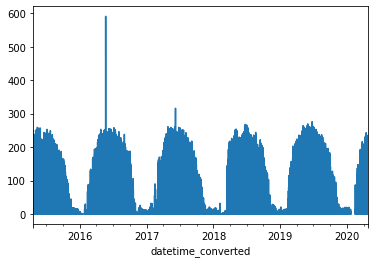

In [640]:
df['Value (kWh)'].plot()
plt.show()

Looks like there are also a couple of outliers in the data that perhaps have to be changed or deleted.

In [641]:
df['Value (kWh)'][df['Value (kWh)']>300]

datetime_converted
2016-05-22 08:00:00+00:00    591.0
2017-06-07 15:00:00+00:00    316.0
Name: Value (kWh), dtype: float64

In [642]:
#let's try to find the values in the neighbouring hours around them and see if this is a realistic value
slice_1 = '2016-05-22 04:00:00+00:00'
slice_2 = '2016-05-22 12:00:00+00:00'

df['Value (kWh)'][(df['Value (kWh)'].index>=slice_1)&(df['Value (kWh)'].index<=slice_2)]

datetime_converted
2016-05-22 04:00:00+00:00     36.0
2016-05-22 05:00:00+00:00     58.0
2016-05-22 06:00:00+00:00    105.0
2016-05-22 07:00:00+00:00    137.0
2016-05-22 08:00:00+00:00    591.0
2016-05-22 09:00:00+00:00    226.0
2016-05-22 10:00:00+00:00    237.0
2016-05-22 11:00:00+00:00    240.0
2016-05-22 12:00:00+00:00    231.0
Name: Value (kWh), dtype: float64

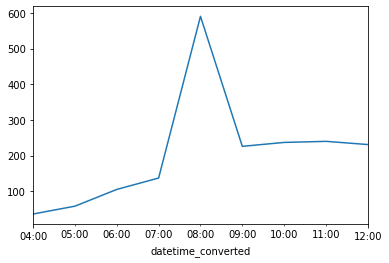

In [643]:
df['Value (kWh)'][(df['Value (kWh)'].index>=slice_1)&(df['Value (kWh)'].index<=slice_2)].plot()
plt.show()

We can see that there is clearly some kinda problem with the data. Let's replace this value with a average of the two consecutive hours

In [644]:
slice_1 = '2016-05-22 07:00:00+00:00'
slice_2 = '2016-05-22 09:00:00+00:00'
# df['Value (kWh)'][(df['Value (kWh)'].index>=slice_1)&(df['Value (kWh)'].index<=slice_2)].mean()
(df['Value (kWh)'][df['Value (kWh)'].index==slice_1].values+df['Value (kWh)'][df['Value (kWh)'].index==slice_2].values)/2

array([181.5])

In [626]:
# slice_1 = '2016-05-22 04:00:00+00:00'
# slice_2 = '2016-05-22 12:00:00+00:00'
# df['Value (kWh)'][(df['Value (kWh)'].index>=slice_1)&(df['Value (kWh)'].index<=slice_2)]

In [649]:
# let's replace with 181.5 kWh
index_val = '2016-05-22 08:00:00+00:00'
# df['Value (kWh)'].index==index_val.replace(value=value_to_repl, inplace=True)
df['Value (kWh)'].loc[index_val] = 181.5

C:\Users\screwdriver\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Sanity check

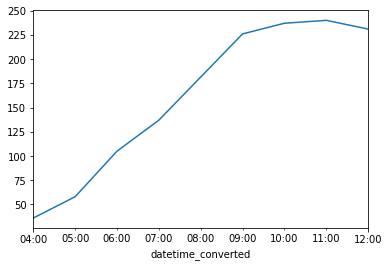

In [650]:
slice_1 = '2016-05-22 04:00:00+00:00'
slice_2 = '2016-05-22 12:00:00+00:00'
df['Value (kWh)'][(df['Value (kWh)'].index>=slice_1)&(df['Value (kWh)'].index<=slice_2)].plot()
plt.show()

Now next value

datetime_converted
2017-06-07 12:00:00+00:00    243.0
2017-06-07 13:00:00+00:00    224.0
2017-06-07 14:00:00+00:00    173.0
2017-06-07 15:00:00+00:00    316.0
2017-06-07 16:00:00+00:00     55.0
2017-06-07 17:00:00+00:00     34.0
2017-06-07 18:00:00+00:00      8.0
Name: Value (kWh), dtype: float64


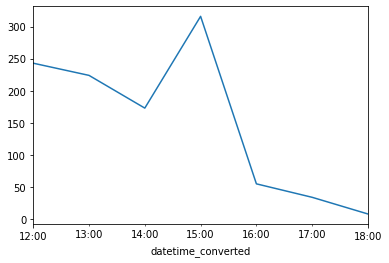

In [651]:
val_index = '2017-06-07 15:00:00+00:00'
slice_1 = '2017-06-07 12:00:00+00:00'
slice_2 = '2017-06-07 18:00:00+00:00'
print(df['Value (kWh)'][(df['Value (kWh)'].index>=slice_1)&(df['Value (kWh)'].index<=slice_2)])
df['Value (kWh)'][(df['Value (kWh)'].index>=slice_1)&(df['Value (kWh)'].index<=slice_2)].plot()
plt.show()

This one is a tough call, but perhaps we also change this value with the average of nearby

In [655]:
slice_1 = '2017-06-07 14:00:00+00:00'
slice_2 = '2017-06-07 16:00:00+00:00'
df['Value (kWh)'].loc[val_index] = (df['Value (kWh)'].loc[slice_1]+df['Value (kWh)'].loc[slice_2])/2

datetime_converted
2017-06-07 12:00:00+00:00    243.0
2017-06-07 13:00:00+00:00    224.0
2017-06-07 14:00:00+00:00    173.0
2017-06-07 15:00:00+00:00    114.0
2017-06-07 16:00:00+00:00     55.0
2017-06-07 17:00:00+00:00     34.0
2017-06-07 18:00:00+00:00      8.0
Name: Value (kWh), dtype: float64


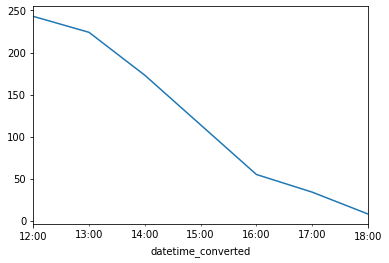

In [656]:
slice_1 = '2017-06-07 12:00:00+00:00'
slice_2 = '2017-06-07 18:00:00+00:00'
print(df['Value (kWh)'][(df['Value (kWh)'].index>=slice_1)&(df['Value (kWh)'].index<=slice_2)])
df['Value (kWh)'][(df['Value (kWh)'].index>=slice_1)&(df['Value (kWh)'].index<=slice_2)].plot()
plt.show()

Should be ready now, let's proceed!

In [475]:
# VALUES TO ATTEND

# Cloud amount (1/8)                 0.155000
# Pressure (msl) (hPa)               0.107132
# Relative humidity (%)              0.107132
# Precipitation intensity (mm/h)     0.323676
# Air temperature (degC)            11.957785
# Dew-point temperature (degC)       3.815732
# Wind direction (deg)               0.583529
# Gust speed (m/s)                   0.565294
# Wind speed (m/s)                   0.583529

### 2. Pressure and relative humidity

Pressure and relative humidity have the same amount of missing data. If we look closer at each of the NaN values, it seems that they are missing on the same dates as majority of all the rest of the data and without a particular reason.

In [476]:
df[df['Pressure (msl) (hPa)'].isnull()]

,Year,m,d,Time,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),Value (kWh)
datetime_converted,,,,,,,,,,,,,,
2015-06-10 10:00:00+00:00,2015,6,10,10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118
2015-09-24 12:00:00+00:00,2015,9,24,12:00,NaN,NaN,NaN,NaN,17.5,NaN,NaN,NaN,NaN,88
2015-10-08 08:00:00+00:00,2015,10,8,08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113
2015-12-18 11:00:00+00:00,2015,12,18,11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-12-18 12:00:00+00:00,2015,12,18,12:00,NaN,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN,0
2016-01-13 12:00:00+00:00,2016,1,13,12:00,NaN,NaN,NaN,NaN,-10.5,NaN,NaN,NaN,NaN,0
2016-01-13 20:00:00+00:00,2016,1,13,20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-01-15 03:00:00+00:00,2016,1,15,03:00,NaN,NaN,NaN,NaN,-13.7,NaN,NaN,NaN,NaN,0
2016-01-17 23:00:00+00:00,2016,1,17,23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [477]:
# we will get the data from the API. Let's mark which columns of data the API can provide.
df[df['Relative humidity (%)'].isnull()]

,Year,m,d,Time,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),Value (kWh)
datetime_converted,,,,,,,,,,,,,,
2015-06-10 10:00:00+00:00,2015,6,10,10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118
2015-09-24 12:00:00+00:00,2015,9,24,12:00,NaN,NaN,NaN,NaN,17.5,NaN,NaN,NaN,NaN,88
2015-10-08 08:00:00+00:00,2015,10,8,08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113
2015-12-18 11:00:00+00:00,2015,12,18,11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-12-18 12:00:00+00:00,2015,12,18,12:00,NaN,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN,0
2016-01-13 12:00:00+00:00,2016,1,13,12:00,NaN,NaN,NaN,NaN,-10.5,NaN,NaN,NaN,NaN,0
2016-01-13 20:00:00+00:00,2016,1,13,20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-01-15 03:00:00+00:00,2016,1,15,03:00,NaN,NaN,NaN,NaN,-13.7,NaN,NaN,NaN,NaN,0
2016-01-17 23:00:00+00:00,2016,1,17,23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### How to deal with missing values in TIMESERIES

Option 1: Complete-case analysis (CCA), also called "list-wise deletion" of cases, consists in discarding observations where values in any of the variables are missing. Complete Case Analysis means literally analysing only those observations for which there is information in all of the variables in the dataset.

* Data is missing completely at random
* No more than 5% of the total dataset contains missing data

Perhaps we could use it on the variables except Air temperature (degC) to save some time.

In [657]:
vars_cca = [var for var in df.columns if (df[var].isnull().mean() < 0.05)&(df[var].isnull().mean() > 0)]
vars_cca

['Cloud amount (1/8)',
 'Pressure (msl) (hPa)',
 'Relative humidity (%)',
 'Precipitation intensity (mm/h)',
 'Dew-point temperature (degC)',
 'Wind direction (deg)',
 'Gust speed (m/s)',
 'Wind speed (m/s)',
 'Value (kWh)']

In [658]:
df = df.dropna(subset=vars_cca)

After removing the NaN values with CCA, only one variable is left with a little more than 8% of NaN - Air Temperature

In [659]:
df.isnull().mean()*100

Year                              0.000000
m                                 0.000000
d                                 0.000000
Time                              0.000000
Cloud amount (1/8)                0.000000
Pressure (msl) (hPa)              0.000000
Relative humidity (%)             0.000000
Precipitation intensity (mm/h)    0.000000
Air temperature (degC)            8.334547
Dew-point temperature (degC)      0.000000
Wind direction (deg)              0.000000
Gust speed (m/s)                  0.000000
Wind speed (m/s)                  0.000000
Value (kWh)                       0.000000
dtype: float64

## Important about imputation

Imputation has to be done over the training set, and then propagated to the test set. For this imputation technique, this means that when selecting the value with which we will replace the NA, we need to do so only by looking at the distribution of the variables in the training set. Then we use the selected value to replace NA both in the train and test set.

However, I believe it was fine to impute power values, as they were indeed meant to be an arbitrary value of 0

In [660]:
# Should we drop Year, m , d and time columns? perhaps not
#let's split the dataset into train and test
target = 'Value (kWh)'
df = df.sort_index(ascending=True)
#splitting dataset
split = int(len(df)-(len(df)/100)*10)
X_train = df[:split]
X_test = df[split:]
y_train = df[target][:split]
y_test = df[target][split:]

In [661]:
X_test.head()

,Year,m,d,Time,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Air temperature (degC),Dew-point temperature (degC),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),Value (kWh)
datetime_converted,,,,,,,,,,,,,,
2019-10-06 04:00:00+00:00,2019,10,6,04:00,0.0,1021.1,92.0,0.0,0.2,-1.0,316.0,5.4,2.9,0.0
2019-10-06 05:00:00+00:00,2019,10,6,05:00,7.0,1021.0,95.0,0.0,0.1,-0.6,312.0,4.2,2.7,4.0
2019-10-06 06:00:00+00:00,2019,10,6,06:00,7.0,1021.1,88.0,0.0,1.4,-0.5,303.0,4.1,2.6,18.0
2019-10-06 07:00:00+00:00,2019,10,6,07:00,7.0,1021.1,83.0,0.0,2.6,0.0,307.0,4.8,2.7,27.0
2019-10-06 08:00:00+00:00,2019,10,6,08:00,7.0,1020.8,77.0,0.0,3.3,-0.3,307.0,5.4,2.5,69.0


## Dealing with Air temperature missing values

Let's first plot the temperature values and see what we can do about it

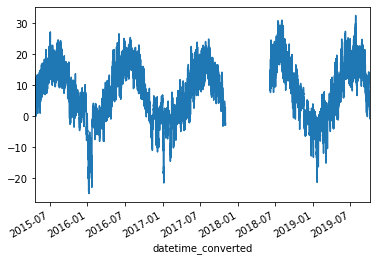

In [662]:
X_train['Air temperature (degC)'].plot()

Looks like there is a huge chunk of data missing during the year 2018. Perhaps we should delete these values from our dataset altogether

In [663]:
# slice_start = '2017-11-01 00:00:00+00:00'
# slice_finish = '2017-11-02 06:00'
# var = 'Air temperature (degC)'
# df_slice = X_train[(X_train.index>=slice_start)&(X_train.index<slice_finish)]
# df_slice[var].plot(figsize=(17,10))

In [664]:
# slice_start = '2017-11-02 06:00:00+00:00'
# slice_finish = '2018-03-31 00:00:00+00:00'
# var = 'Air temperature (degC)'
# df_slice = X_train[(X_train.index>=slice_start)&(X_train.index<slice_finish)]
# df_slice[var].plot(figsize=(17,10))
# df_slice

Missing data big chunks:

* from  2018-03-31 23:00 -> until 2018-06-07 19:00    

and no air temp 

* from 2017-11-02 06:00 -> until 2018-03-31 23:00

Thus, we will remove this chunk of the dataframe without air temp as well.
> from 2017-11-02 06:00 -> 2018-03-31 23:00

In [665]:
slice_start = '2017-11-02 06:00'
slice_end = '2018-03-31 23:00'
# X_train = X_train.drop((X_train.index>=slice_start)&(X_train.index<slice_end))
X_train = X_train.drop(X_train.loc[(X_train.index > slice_start)&(X_train.index<=slice_end)].index)
y_train = y_train.drop(y_train.loc[(y_train.index > slice_start)&(y_train.index<=slice_end)].index)

In [666]:
# no more missing values

In [667]:
X_train['Air temperature (degC)'].isnull().mean()*100

0.0

Basically, all of this means that we could have dropped the Air temperature missing values with CCA since they are anyways all sequential and there is no way for us to impute such an amount of missing data sequentially.
Thus, will drop them for this DF and save the version of a DF prior to splitting into Train and Test

In [669]:
df = df.dropna(subset=['Air temperature (degC)'])

# df
#let's save this dataframe as a csv file now.
# df.to_csv('../datasets/solar_p_data/df_removed_nans.csv')

### Can start from here now, loading the data

In [670]:
# df.to_csv('../datasets/solar_p_data/df_removed_nans.csv')
df = pd.read_csv('../datasets/solar_p_data/df_removed_nans.csv', delimiter=',')
df['datetime_converted'] = pd.to_datetime(df['datetime_converted'], utc=True)
df = df.set_index(pd.DatetimeIndex(df['datetime_converted'],dayfirst=True))
df = df.drop(columns='datetime_converted')

In [671]:
df.columns

Index(['Year', 'm', 'd', 'Time', 'Cloud amount (1/8)', 'Pressure (msl) (hPa)',
       'Relative humidity (%)', 'Precipitation intensity (mm/h)',
       'Air temperature (degC)', 'Dew-point temperature (degC)',
       'Wind direction (deg)', 'Gust speed (m/s)', 'Wind speed (m/s)',
       'Value (kWh)'],
      dtype='object')

In [672]:
# df['Value (kWh)'] = pd.to_numeric(df['Value (kWh)'])

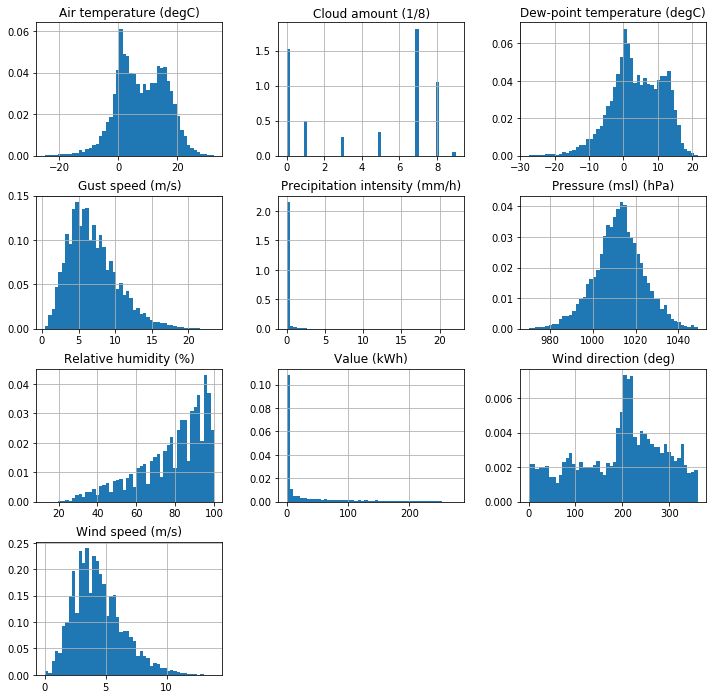

In [673]:
vars_plot = ['Cloud amount (1/8)',
 'Pressure (msl) (hPa)',
 'Relative humidity (%)',
 'Precipitation intensity (mm/h)',
 'Dew-point temperature (degC)',
 'Wind direction (deg)',
 'Gust speed (m/s)',
 'Wind speed (m/s)','Air temperature (degC)','Value (kWh)']
df[vars_plot].hist(bins=50, density=True, figsize=(12,12))
plt.show()

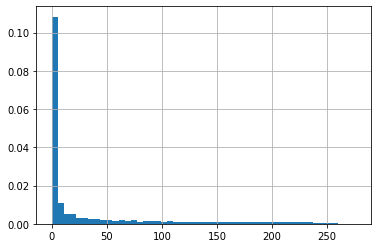

In [674]:
df['Value (kWh)'].hist(bins=50, density=True)
plt.show()

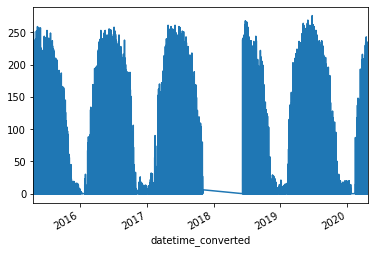

In [675]:
df['Value (kWh)'].plot()

# Feature engineering continued: let's look at correlation of variables with our target

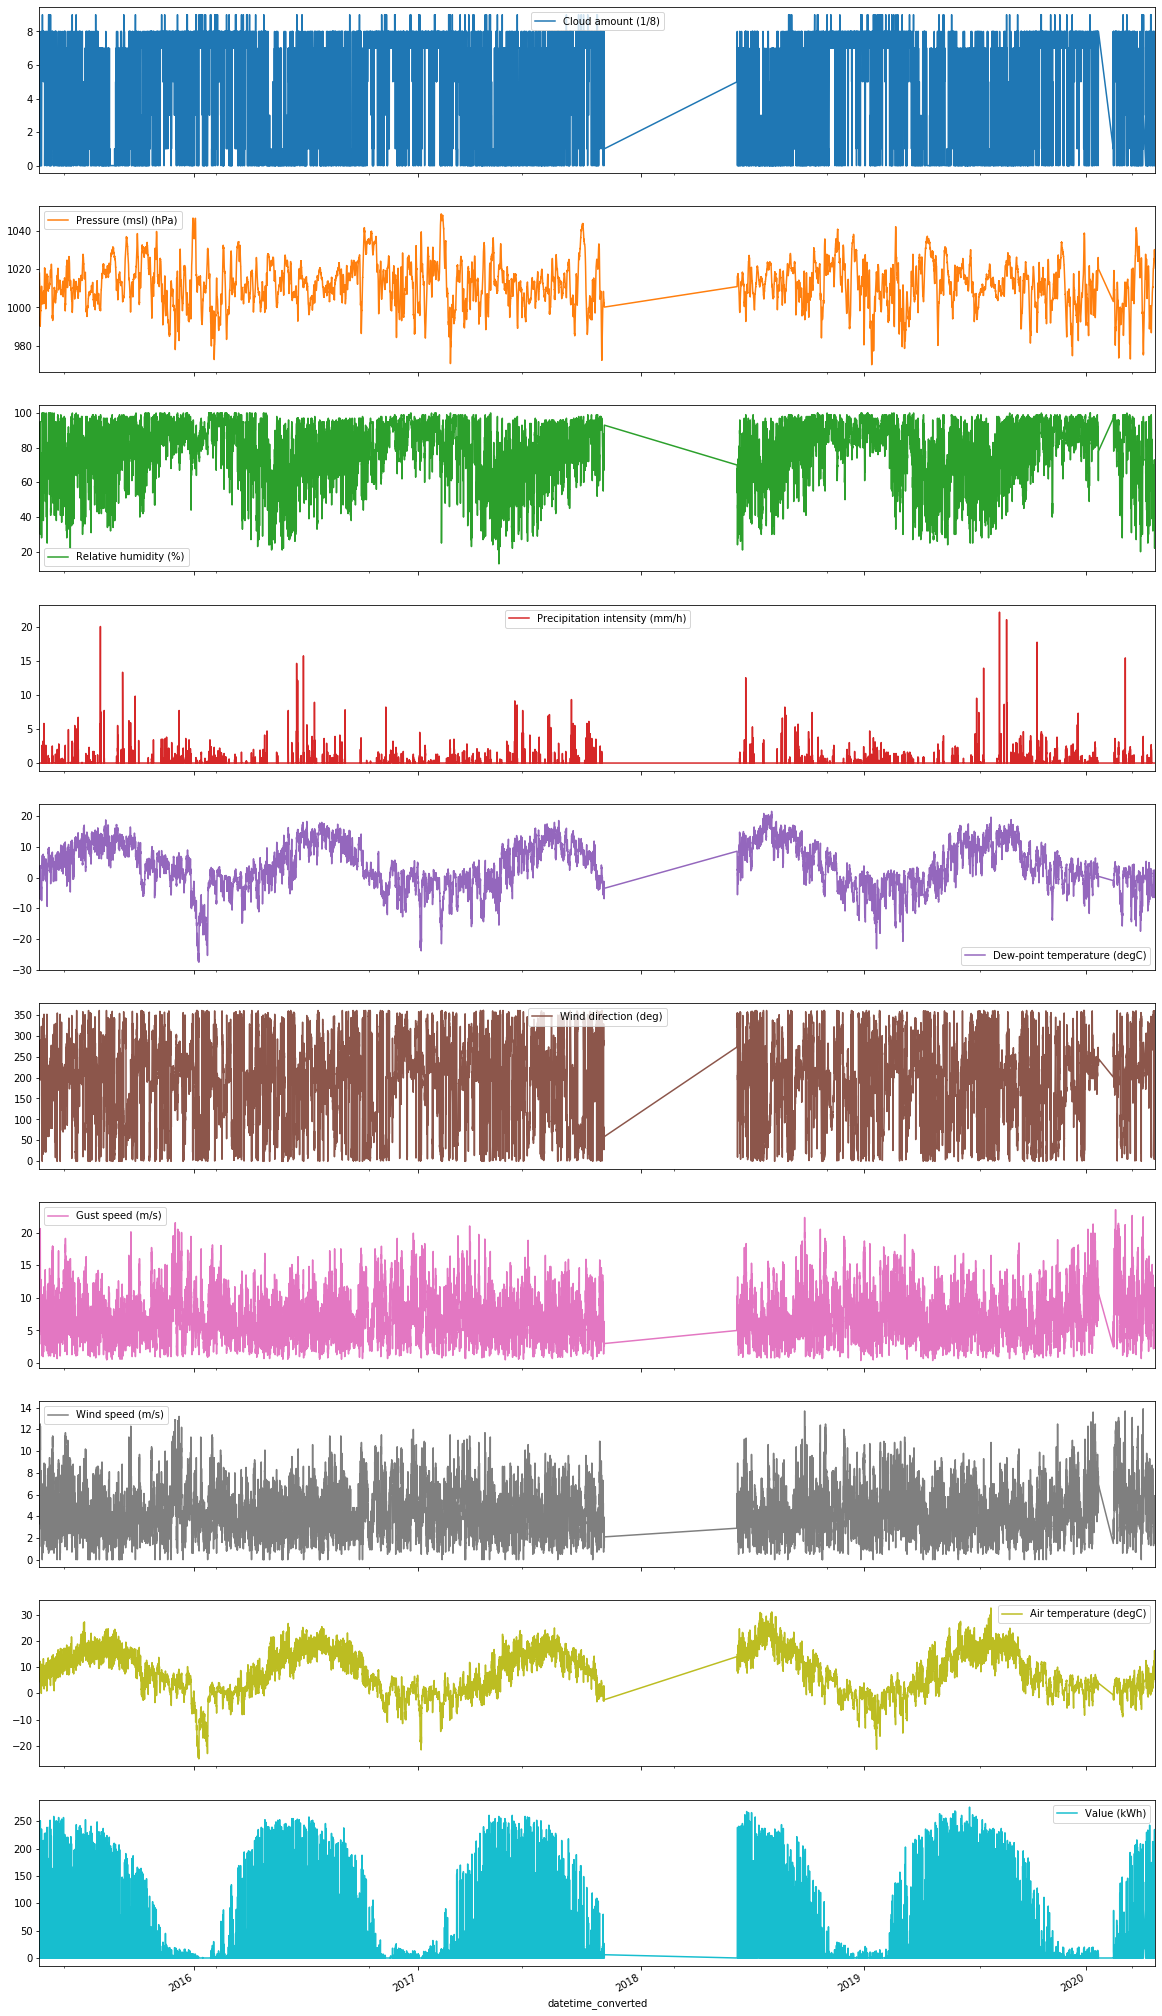

In [688]:
vars_plot = ['Cloud amount (1/8)',
 'Pressure (msl) (hPa)',
 'Relative humidity (%)',
 'Precipitation intensity (mm/h)',
 'Dew-point temperature (degC)',
 'Wind direction (deg)',
 'Gust speed (m/s)',
 'Wind speed (m/s)','Air temperature (degC)','Value (kWh)']

df[vars_plot].plot(subplots=True,figsize=(20,40))
plt.show()

In [689]:
#our variables look fine, no outliers as it seems

#let's run stationarity tests on data

## Stationarity

In [725]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    Source2: https://www.youtube.com/watch?v=JntA9XaTebs&t=1545s
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original %s' %ts)
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
#     plt.title('Rolling Mean & Standard Deviation for ')
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if dftest[1] <= 0.05:
        print('Strong evidence against the null hypothesis')
        print(' Reject the null hypothesis')
        print('Data has no unit root and is stationary')

    else:
        print('Weak evidence against the null hypothesis')
        print(' Fail to reject the null hypothesis')
        print('Data has a unit root and is non-stationary')


-----------------------
Variable:  Cloud amount (1/8)
-----------------------


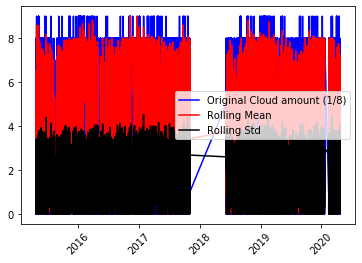

Results of Dickey-Fuller Test:
Test Statistic                   -18.842670
p-value                            0.000000
# Lags Used                       42.000000
Number of Observations Used    37725.000000
Critical Value (1%)               -3.430523
Critical Value (5%)               -2.861617
Critical Value (10%)              -2.566811
dtype: float64
Strong evidence against the null hypothesis
 Reject the null hypothesis
Data has no unit root and is stationary
-----------------------
Variable:  Pressure (msl) (hPa)
-----------------------


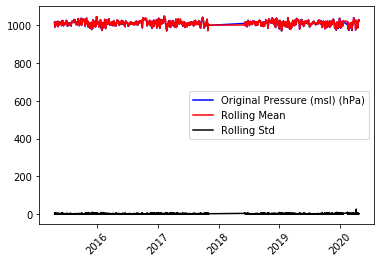

Results of Dickey-Fuller Test:
Test Statistic                -1.285240e+01
p-value                        5.318541e-24
# Lags Used                    5.300000e+01
Number of Observations Used    3.771400e+04
Critical Value (1%)           -3.430523e+00
Critical Value (5%)           -2.861617e+00
Critical Value (10%)          -2.566811e+00
dtype: float64
Strong evidence against the null hypothesis
 Reject the null hypothesis
Data has no unit root and is stationary
-----------------------
Variable:  Relative humidity (%)
-----------------------


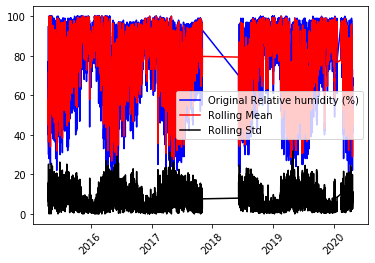

Results of Dickey-Fuller Test:
Test Statistic                -1.339779e+01
p-value                        4.630159e-25
# Lags Used                    5.200000e+01
Number of Observations Used    3.771500e+04
Critical Value (1%)           -3.430523e+00
Critical Value (5%)           -2.861617e+00
Critical Value (10%)          -2.566811e+00
dtype: float64
Strong evidence against the null hypothesis
 Reject the null hypothesis
Data has no unit root and is stationary
-----------------------
Variable:  Precipitation intensity (mm/h)
-----------------------


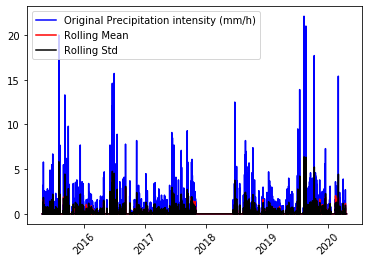

Results of Dickey-Fuller Test:
Test Statistic                   -42.740593
p-value                            0.000000
# Lags Used                       13.000000
Number of Observations Used    37754.000000
Critical Value (1%)               -3.430523
Critical Value (5%)               -2.861617
Critical Value (10%)              -2.566811
dtype: float64
Strong evidence against the null hypothesis
 Reject the null hypothesis
Data has no unit root and is stationary
-----------------------
Variable:  Dew-point temperature (degC)
-----------------------


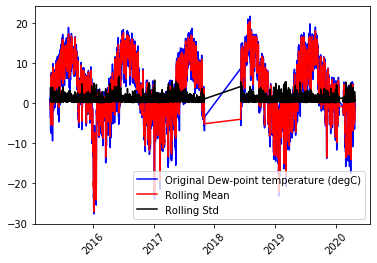

Results of Dickey-Fuller Test:
Test Statistic                -7.768142e+00
p-value                        9.071227e-12
# Lags Used                    4.800000e+01
Number of Observations Used    3.771900e+04
Critical Value (1%)           -3.430523e+00
Critical Value (5%)           -2.861617e+00
Critical Value (10%)          -2.566811e+00
dtype: float64
Strong evidence against the null hypothesis
 Reject the null hypothesis
Data has no unit root and is stationary
-----------------------
Variable:  Wind direction (deg)
-----------------------


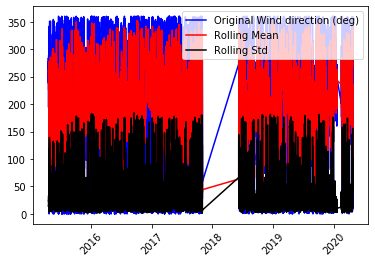

Results of Dickey-Fuller Test:
Test Statistic                -1.869998e+01
p-value                        2.037177e-30
# Lags Used                    4.900000e+01
Number of Observations Used    3.771800e+04
Critical Value (1%)           -3.430523e+00
Critical Value (5%)           -2.861617e+00
Critical Value (10%)          -2.566811e+00
dtype: float64
Strong evidence against the null hypothesis
 Reject the null hypothesis
Data has no unit root and is stationary
-----------------------
Variable:  Gust speed (m/s)
-----------------------


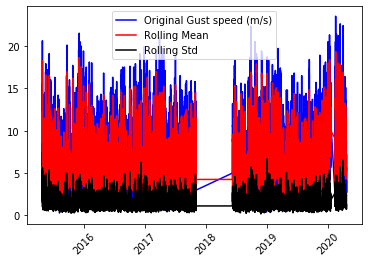

Results of Dickey-Fuller Test:
Test Statistic                   -20.636540
p-value                            0.000000
# Lags Used                       53.000000
Number of Observations Used    37714.000000
Critical Value (1%)               -3.430523
Critical Value (5%)               -2.861617
Critical Value (10%)              -2.566811
dtype: float64
Strong evidence against the null hypothesis
 Reject the null hypothesis
Data has no unit root and is stationary
-----------------------
Variable:  Wind speed (m/s)
-----------------------


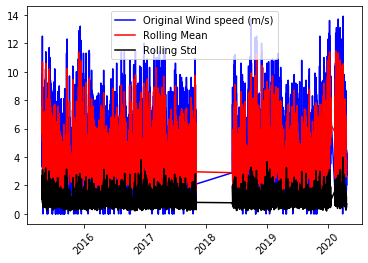

Results of Dickey-Fuller Test:
Test Statistic                   -20.454712
p-value                            0.000000
# Lags Used                       52.000000
Number of Observations Used    37715.000000
Critical Value (1%)               -3.430523
Critical Value (5%)               -2.861617
Critical Value (10%)              -2.566811
dtype: float64
Strong evidence against the null hypothesis
 Reject the null hypothesis
Data has no unit root and is stationary
-----------------------
Variable:  Air temperature (degC)
-----------------------


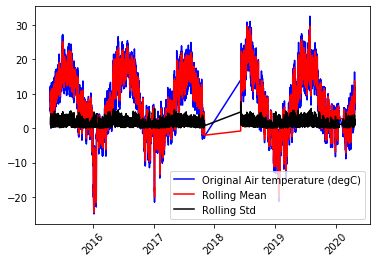

Results of Dickey-Fuller Test:
Test Statistic                -5.762206e+00
p-value                        5.638229e-07
# Lags Used                    4.900000e+01
Number of Observations Used    3.771800e+04
Critical Value (1%)           -3.430523e+00
Critical Value (5%)           -2.861617e+00
Critical Value (10%)          -2.566811e+00
dtype: float64
Strong evidence against the null hypothesis
 Reject the null hypothesis
Data has no unit root and is stationary
-----------------------
Variable:  Value (kWh)
-----------------------


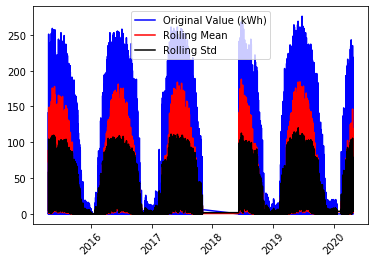

Results of Dickey-Fuller Test:
Test Statistic                -8.582314e+00
p-value                        7.669499e-14
# Lags Used                    5.300000e+01
Number of Observations Used    3.771400e+04
Critical Value (1%)           -3.430523e+00
Critical Value (5%)           -2.861617e+00
Critical Value (10%)          -2.566811e+00
dtype: float64
Strong evidence against the null hypothesis
 Reject the null hypothesis
Data has no unit root and is stationary


In [727]:
for var in vars_plot:
    print("-----------------------")
    print("Variable: ", var)
    print('-----------------------')
    test_stationarity(df=df, ts=var)

Looks like all data is stationary Q.Q

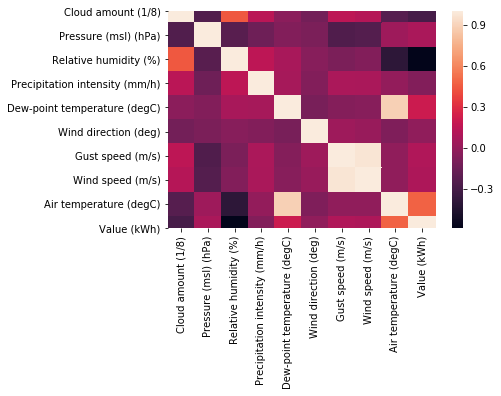

In [742]:
correlation = df[vars_plot].corr()
sns.heatmap(correlation)

In [748]:
correlation

,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Dew-point temperature (degC),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),Air temperature (degC),Value (kWh)
Cloud amount (1/8),1.000000,-0.250463,0.442936,0.138730,-0.030612,-0.122008,0.151486,0.124252,-0.228729,-0.292852
Pressure (msl) (hPa),-0.250463,1.000000,-0.222134,-0.136280,-0.064374,-0.088921,-0.255388,-0.240173,0.037610,0.077677
Relative humidity (%),0.442936,-0.222134,1.000000,0.151911,0.073369,-0.043220,-0.091062,-0.066747,-0.396608,-0.587904
Precipitation intensity (mm/h),0.138730,-0.136280,0.151911,1.000000,0.063733,-0.064632,0.085917,0.078635,-0.004728,-0.064000
Dew-point temperature (degC),-0.030612,-0.064374,0.073369,0.063733,1.000000,-0.101595,-0.059463,-0.044571,0.882811,0.210307
Wind direction (deg),-0.122008,-0.088921,-0.043220,-0.064632,-0.101595,1.000000,0.032728,0.014114,-0.073575,-0.016430
Gust speed (m/s),0.151486,-0.255388,-0.091062,0.085917,-0.059463,0.032728,1.000000,0.971835,-0.014389,0.101355
Wind speed (m/s),0.124252,-0.240173,-0.066747,0.078635,-0.044571,0.014114,0.971835,1.000000,-0.012420,0.089838
Air temperature (degC),-0.228729,0.037610,-0.396608,-0.004728,0.882811,-0.073575,-0.014389,-0.012420,1.000000,0.477920
Value (kWh),-0.292852,0.077677,-0.587904,-0.064000,0.210307,-0.016430,0.101355,0.089838,0.477920,1.000000


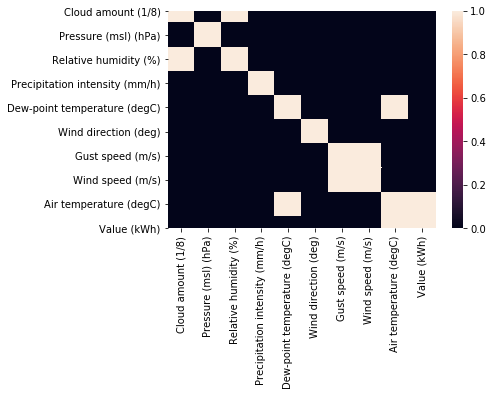

In [750]:
sns.heatmap(correlation>0.4)

In [739]:
correlation['Value (kWh)']

Cloud amount (1/8)               -0.292852
Pressure (msl) (hPa)              0.077677
Relative humidity (%)            -0.587904
Precipitation intensity (mm/h)   -0.064000
Dew-point temperature (degC)      0.210307
Wind direction (deg)             -0.016430
Gust speed (m/s)                  0.101355
Wind speed (m/s)                  0.089838
Air temperature (degC)            0.477920
Value (kWh)                       1.000000
Name: Value (kWh), dtype: float64

## High correlated variables:
* Air temperature and Dew-point temperature have a correlation over 0.7
* Wind speed and Gust of wind have correlation of almost 0.97 -> Perhaps we can delete one of those variables

In [752]:
df = df.drop(columns=['Gust speed (m/s)'])

In [754]:
df.columns

Index(['Year', 'm', 'd', 'Time', 'Cloud amount (1/8)', 'Pressure (msl) (hPa)',
       'Relative humidity (%)', 'Precipitation intensity (mm/h)',
       'Air temperature (degC)', 'Dew-point temperature (degC)',
       'Wind direction (deg)', 'Wind speed (m/s)', 'Value (kWh)'],
      dtype='object')

# thought: make time into a variable that would show if sun is up or not.

# LET'S TRY TRAINING!

In [761]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR, DynamicVAR, VARMAX
from statsmodels.tools.eval_measures import rmse

### Splitting into train and test

### Selecting the model:
1. Let's try SARIMAX

In [837]:
df.columns

Index(['Year', 'm', 'd', 'Time', 'Cloud amount (1/8)', 'Pressure (msl) (hPa)',
       'Relative humidity (%)', 'Precipitation intensity (mm/h)',
       'Air temperature (degC)', 'Dew-point temperature (degC)',
       'Wind direction (deg)', 'Wind speed (m/s)', 'Value (kWh)'],
      dtype='object')

In [854]:
df['Time']=pd.to_datetime(df['Time'])
df['Time']=df['Time'].dt.hour
df['m']

datetime_converted
2015-04-22 01:00:00+00:00    4
2015-04-22 02:00:00+00:00    4
2015-04-22 03:00:00+00:00    4
2015-04-22 04:00:00+00:00    4
2015-04-22 05:00:00+00:00    4
                            ..
2020-04-22 19:00:00+00:00    4
2020-04-22 20:00:00+00:00    4
2020-04-22 21:00:00+00:00    4
2020-04-22 22:00:00+00:00    4
2020-04-22 23:00:00+00:00    4
Name: m, Length: 37768, dtype: int64

In [902]:
# df.to_csv('../datasets/solar_p_data/df_ready_to_train.csv')
df = pd.read_csv('../datasets/solar_p_data/df_ready_to_train.csv', delimiter=',')
df['datetime_converted'] = pd.to_datetime(df['datetime_converted'], utc=True)
df = df.set_index(pd.DatetimeIndex(df['datetime_converted'],dayfirst=True))
df = df.drop(columns='datetime_converted')

In [903]:
target = 'Value (kWh)'
df = df.sort_index(ascending=True)
#splitting dataset
split = int(len(df)-(len(df)/100)*10)
X_train = df[:split]
X_test = df[split:]
y_train = df[target][:split]
y_test = df[target][split:]

In [904]:
exog_vars = ['m','d','Time','Cloud amount (1/8)',
 'Pressure (msl) (hPa)',
 'Relative humidity (%)',
 'Precipitation intensity (mm/h)',
 'Dew-point temperature (degC)',
 'Wind direction (deg)',
 'Wind speed (m/s)',
 'Air temperature (degC)']

In [905]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR, DynamicVAR, VARMAX
from statsmodels.tools.eval_measures import rmse

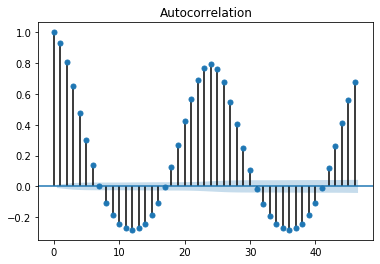

In [858]:
plot_acf(y_train);

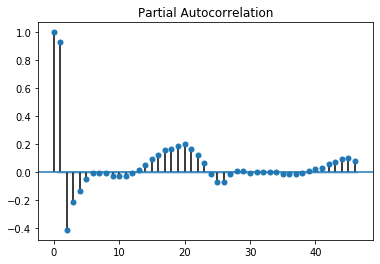

In [859]:
plot_pacf(y_train);

In [906]:
model = SARIMAX(y_train,exog=X_train[exog_vars],order=(0,0,0),enforce_invertibility=False)
results = model.fit()
results.summary()

C:\Users\screwdriver\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  if date_index and not is_monotonic:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:            Value (kWh)   No. Observations:                33991
Model:                        SARIMAX   Log Likelihood             -178016.655
Date:                Fri, 24 Apr 2020   AIC                         356057.310
Time:                        22:40:55   BIC                         356158.517
Sample:                             0   HQIC                        356089.592
                              - 33991                                         
Covariance Type:                  opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
m                                 -1.3495      0.158     -8.542      0.000      -1.659      -1.040
d                                  0.0620      0.029      2.161      0.031       0.006       0.118
Time                            -1.04e-14   9.28e-12     -0.001      0.999   -1.82e-11    1.82e-11
Cloud amount (1/8)                -0.8140      0.094     -8.652      0.000      -0.998      -0.630
Pressure (msl) (hPa)              -0.0952      0.008    -12.118      0.000      -0.111      -0.080
Relative humidity (%)              0.9382      0.088     10.655      0.000       0.766       1.111
Precipitation intensity (mm/h)    -1.0920      0.879     -1.242      0.214      -2.815       0.631
Dew-point temperature (degC)     -11.3008      0.352    -32.119      0.000     -11.990     -10.611
Wind direction (deg)              -0.0156      0.003     -5.168      0.000      -0.021      -0.010
Wind speed (m/s)                   2.4738      0.129     19.124      0.000       2.220       2.727
Air temperature (degC)            13.1328      0.337     39.021      0.000      12.473      13.792
sigma2                          2072.4580     13.791    150.275      0.000    2045.428    2099.488
===================================================================================
Ljung-Box (Q):                   192631.59   Jarque-Bera (JB):             12734.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.02e+18. Standard errors may be unstable.
"""

In [896]:
start=1
end=36
exog_forecast = X_test[exog_vars]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,1,1) Predictions')

In [897]:
prediction = pd.DataFrame()
start_slice='2019-10-20 14:00:00+00:00'
end_slice='2019-10-22 01:00:00+00:00'
prediction['predicted'] = predictions.values
len(prediction)
prediction['y_test'] = y_test.loc[start_slice:end_slice].values

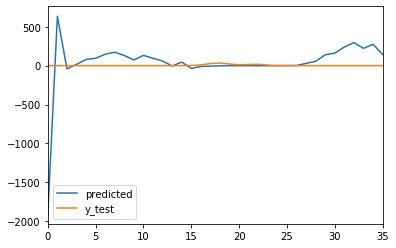

In [898]:
prediction.plot()

In [899]:
prediction

,predicted,y_test
0,-1906.996562,0.0
1,635.551769,0.0
2,-41.412071,0.0
3,16.675992,0.0
4,79.162230,0.0
5,95.390772,0.0
6,147.069636,0.0
7,173.416541,0.0
8,130.256296,0.0
9,73.100936,0.0


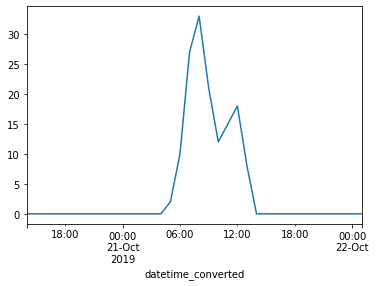

In [900]:
y_test.loc[start_slice:end_slice].plot()

# Let's Try Tensorflow!